In this notebook I will try to use Efficient similar to previous notebook but this time I will use the EfficientNet B4 model, which is larger than B0. I'll omit the details that were covered in previous notebook and just implement the new model and evaluate.

In [1]:
%load_ext autoreload
%autoreload 2

RANDOM_STATE = 2025

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import os
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

dataset_dir = "../data/cloth_dataset"
csv_file_name = "aarong_dataset_clean_final.csv"

# Load CSV File
csv_file = os.path.join(dataset_dir, csv_file_name)
df = pd.read_csv(csv_file)

single_label_features = ['fabric_types_clean', 'wear_types_clean']
multilabel_features = ['colors_clean', 'textures_clean', 'value_additions_clean']


# Remove rare labels
from my_utils.dataset_utils import remove_rare_labels

for column in single_label_features + multilabel_features:
	# Replace NaN values with empty strings
	df[column] = df[column].fillna('')

	# Remove rare labels
	df[column] = remove_rare_labels(df[column], min_samples_threshold=50)


# Encode labels
from my_utils.preprocessing_utils import ml_binarizer, onehot_encode

for column_name in single_label_features:
	df = onehot_encode(df, column_name)

for column_name in multilabel_features:
	df = ml_binarizer(df, column_name)


In [3]:
# Train/Val/Test Split in 70/15/15 ratio

from sklearn.model_selection import train_test_split

train_df, val_test_df = train_test_split(df, test_size=0.3, random_state=RANDOM_STATE)
val_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=RANDOM_STATE)

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

from my_utils.CustomDataset import CustomMTLDataset
from torch.utils.data import DataLoader

train_ds = CustomMTLDataset(train_df, os.path.join(dataset_dir, 'images'), transform=transform)
val_ds = CustomMTLDataset(val_df, os.path.join(dataset_dir, 'images'), transform=transform)
test_ds = CustomMTLDataset(test_df, os.path.join(dataset_dir, 'images'), transform=transform)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True) 
test_loader = DataLoader(test_ds, batch_size=8, shuffle=False)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False)

In [4]:
import torch.nn as nn
from torchvision.models import efficientnet_b4, EfficientNet_B4_Weights

def generate_custom_head(shared_dim, output_dim):
	return nn.Sequential(
		nn.Linear(shared_dim, 256),
		nn.ReLU(),
		nn.Dropout(0.3),
		nn.Linear(256, output_dim)
	)

class MTLModelEfficientNet(nn.Module):
	def __init__(self, fabric_dim, wear_dim, color_dim, texture_dim, value_add_dim, freeze_backbone=False):
		super(MTLModelEfficientNet, self).__init__()
		self.backbone = efficientnet_b4(weights=EfficientNet_B4_Weights.IMAGENET1K_V1)

		if freeze_backbone:
			for param in self.backbone.parameters():
				param.requires_grad = False

		# Remove the classifier head
		self.backbone.classifier = nn.Identity()
		self.shared_dim = 1792  				# Output of EfficientNet-B4's second last layer

		self.heads = nn.ModuleDict({
			'fabric': generate_custom_head(self.shared_dim, fabric_dim),
			'wear': generate_custom_head(self.shared_dim, wear_dim),
			'color': generate_custom_head(self.shared_dim, color_dim),
			'texture': generate_custom_head(self.shared_dim, texture_dim),
			'value_add': generate_custom_head(self.shared_dim, value_add_dim),
		})

	def forward(self, x):
		features = self.backbone(x)
		return {task: head(features) for task, head in self.heads.items()}

In [5]:
def calc_class_weights(dataloader, tasks):
    total_counts = {task: {'pos': None, 'neg': None} for task in tasks}
    
    for _, labels in dataloader:
        for task in tasks:
            # contains (batch_size, num_labels)
            label_tensor = labels[task]
            if total_counts[task]['pos'] is None:
                total_counts[task]['pos'] = label_tensor.sum(dim=0)
                total_counts[task]['neg'] = (1 - label_tensor).sum(dim=0)
            else:
                total_counts[task]['pos'] += label_tensor.sum(dim=0)
                total_counts[task]['neg'] += (1 - label_tensor).sum(dim=0)

    class_weights = {}
    for task in tasks:
        pos = total_counts[task]['pos']
        neg = total_counts[task]['neg']
        weight = neg / (pos + 1e-5)  # avoiding div by zero
        class_weights[task] = weight

	# returns Dict[str, Tensor] representing class weights for each task
    return class_weights

from my_utils.dataset_utils import get_all_labels

task_labels = {
	'fabric': get_all_labels(train_df['fabric_types_clean'], allow_empty=False),
	'wear': get_all_labels(train_df['wear_types_clean'], allow_empty=False),
	'color': get_all_labels(train_df['colors_clean'], allow_empty=False),
	'texture': get_all_labels(train_df['textures_clean'], allow_empty=True),
	'value_add': get_all_labels(train_df['value_additions_clean'], allow_empty=True),
}


In [6]:
import torch
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report
from tqdm import tqdm
import json
import numpy as np

def run_epoch(model, loader, optimizer, device, is_train=True, threshold=0.5, class_weights=None):
	if is_train:
		model.train()
	else:
		model.eval()

	total_loss = 0.0
	total_unweighted_loss = 0.0

	all_preds = {k: [] for k in model.heads}
	all_targets = {k: [] for k in model.heads}

	for images, labels in tqdm(loader):
		images = images.to(device)
		labels = {k: v.to(device) for k, v in labels.items()}

		if is_train:
			optimizer.zero_grad()

		with torch.set_grad_enabled(is_train):
			outputs = model(images)
			losses = []
			unweighted_losses = []

			for task in outputs:
				unweighted_loss = torch.nn.functional.binary_cross_entropy_with_logits(outputs[task], labels[task])

				if class_weights and task in class_weights:
					weights = class_weights[task].to(device)
					loss = torch.nn.functional.binary_cross_entropy_with_logits(outputs[task], labels[task], weight=weights)
				else:
					loss = unweighted_loss
					
				losses.append(loss)
				unweighted_losses.append(unweighted_loss)

				if not is_train:
					probs = torch.sigmoid(outputs[task])
					preds = (probs > threshold).int()
					all_preds[task].extend(preds.cpu().numpy())
					all_targets[task].extend(labels[task].cpu().numpy())

			batch_loss = sum(losses)
			total_loss += batch_loss.item()

			total_unweighted_loss += (sum(unweighted_losses)).item()

			if is_train:
				batch_loss.backward()
				optimizer.step()

	avg_loss = total_loss / len(loader)
	avg_unweighted_loss = total_unweighted_loss / len(loader)

	if not is_train:
		metrics = {}

		for task in all_preds:
			# Class-wise metrics
			report = classification_report(all_targets[task], all_preds[task], target_names=task_labels[task], output_dict=True, zero_division=0)

			# Compute predicted support
			pred_counts = np.sum(np.array(all_preds[task]), axis=0)
			predicted_support = dict(zip(task_labels[task], pred_counts.tolist()))

			metrics[task] = {
				'f1': f1_score(all_targets[task], all_preds[task], average='micro', zero_division=0),
				'precision': precision_score(all_targets[task], all_preds[task], average='micro', zero_division=0),
				'recall': recall_score(all_targets[task], all_preds[task], average='micro', zero_division=0),
				'accuracy': accuracy_score(all_targets[task], all_preds[task]),

				'classwise_metrics':  {
					class_label : {
						'precision': report[class_label]['precision'],
						'recall': report[class_label]['recall'],
						'f1': report[class_label]['f1-score'],
						'support': report[class_label]['support'],
						'predicted_support': predicted_support[class_label],
					} for class_label in task_labels[task]
				}
			}

		return avg_loss, metrics
	
	else:
		return avg_loss, avg_unweighted_loss


def train_model(model, train_loader, val_loader, optimizer, device, num_epochs=10, threshold=0.5, use_class_weights=False, verbose=True, model_name=''):
	model.to(device)
	best_val_loss = float('inf')
	patience = 3
	patience_counter = 0

	if not model_name:
		model_name = model.__class__.__name__ + pd.Timestamp.now().strftime("%Y%m%d-%H%M%S")

	best_model_path = os.path.join('../data', 'model_weights', f'best_model-{model_name}.pt')
	history_path = os.path.join('../data', 'model_weights', f'history-{model_name}.json')

	history = {
		'train_loss': [],
		'unweighted_train_loss': [],
		'val_loss': [],
		'val_metrics': [],
		'best_epoch': 0
	}

	class_weights = calc_class_weights(train_loader, model.heads.keys()) if use_class_weights else None

	for epoch in range(num_epochs):
		print(f"\nEpoch {epoch+1}/{num_epochs}")
		train_loss, unweighted_train_loss = run_epoch(model, train_loader, optimizer, device, is_train=True, class_weights=class_weights)
		val_loss, val_metrics = run_epoch(model, val_loader, optimizer, device, is_train=False, threshold=threshold)

		history['train_loss'].append(train_loss)
		history['unweighted_train_loss'].append(unweighted_train_loss)
		history['val_loss'].append(val_loss)
		history['val_metrics'].append(val_metrics)

		print(f"Train Loss: {train_loss:.4f}")
		print(f"Val Loss: {val_loss:.4f}")

		if verbose:
			for task, task_metrics in val_metrics.items():
				print("Metrics for task:", task)
				for metric_name, metric_value in task_metrics.items():
					print(f"\t[Val {metric_name}]: {metric_value:.4f}")

		# Early stopping
		if val_loss < best_val_loss:
			best_val_loss = val_loss
			patience_counter = 0
			torch.save(model.state_dict(), best_model_path)
			history['best_epoch'] = epoch
		else:
			patience_counter += 1
			if patience_counter >= patience:
				print("Early stopping triggered.")
				break

	# Save the training history
	with open(history_path, 'w') as f:
		json.dump(history, f)
		
	return history


def evaluate_on_test(model, model_weight_path, test_loader, device, threshold=0.5, verbose=False):
	model.to(device)

	# Load saved weights
	model.load_state_dict(torch.load(model_weight_path, map_location=device))

	with torch.no_grad():
		test_loss, test_metrics = run_epoch(model=model, loader=test_loader, optimizer=None, device=device, is_train=False, threshold=threshold)

	if verbose:
		print(f"\nTest Set Performance:\nTest Loss: {test_loss:.4f}")
		for task, task_metrics in test_metrics.items():
			print(f"\nTask: {task}")
			for metric_name, value in task_metrics.items():
				if metric_name == 'f1':
					print(f"  {metric_name}: {value:.4f}")
			
	test_metric_path = os.path.join('../data', 'model_weights', f'test_metrics-{model_weight_path.split("/")[-1]}.json')

	with open(test_metric_path, 'w') as f:
		json.dump({'test_loss': test_loss, 'test_metrics': test_metrics}, f)
		
	return test_loss, test_metrics

In [7]:
model = MTLModelEfficientNet(
	fabric_dim=len(train_ds.label_columns['fabric']),
	wear_dim=len(train_ds.label_columns['wear']),
	color_dim=len(train_ds.label_columns['color']),
	texture_dim=len(train_ds.label_columns['texture']),
	value_add_dim=len(train_ds.label_columns['value_add']),
	freeze_backbone=False
)

optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 235MB/s]


Using device: cuda


In [8]:
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=10,
    threshold=0.5,
	use_class_weights=True,
	verbose=False,
	model_name='efficientnet_b4_mtl_th0.5_cw'
)



Epoch 1/10


100%|██████████| 62/62 [00:04<00:00, 13.51it/s]


Train Loss: 15.0237
Val Loss: 1.2186

Epoch 2/10


100%|██████████| 62/62 [00:04<00:00, 13.61it/s]


Train Loss: 11.1589
Val Loss: 1.1110

Epoch 3/10


100%|██████████| 62/62 [00:04<00:00, 13.71it/s]


Train Loss: 9.6051
Val Loss: 1.0845

Epoch 4/10


100%|██████████| 62/62 [00:04<00:00, 13.20it/s]


Train Loss: 8.3444
Val Loss: 1.0417

Epoch 5/10


100%|██████████| 62/62 [00:05<00:00, 12.26it/s]


Train Loss: 7.1227
Val Loss: 1.0694

Epoch 6/10


100%|██████████| 62/62 [00:04<00:00, 13.51it/s]


Train Loss: 5.8892
Val Loss: 1.0437

Epoch 7/10


100%|██████████| 62/62 [00:05<00:00, 12.12it/s]


Train Loss: 5.2663
Val Loss: 1.0474
Early stopping triggered.


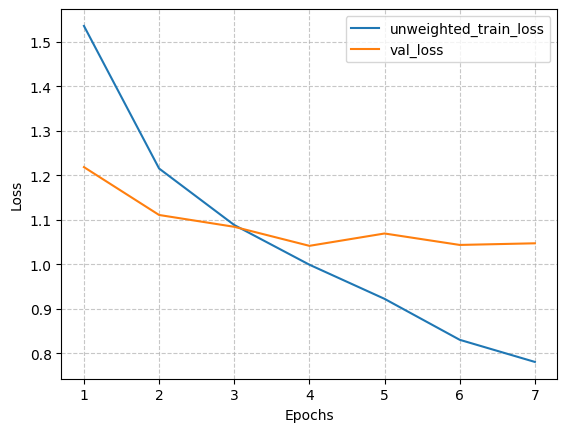

In [9]:
import matplotlib.pyplot as plt
from my_utils.plot_utils import plot_train_val_loss

plot_train_val_loss(history)

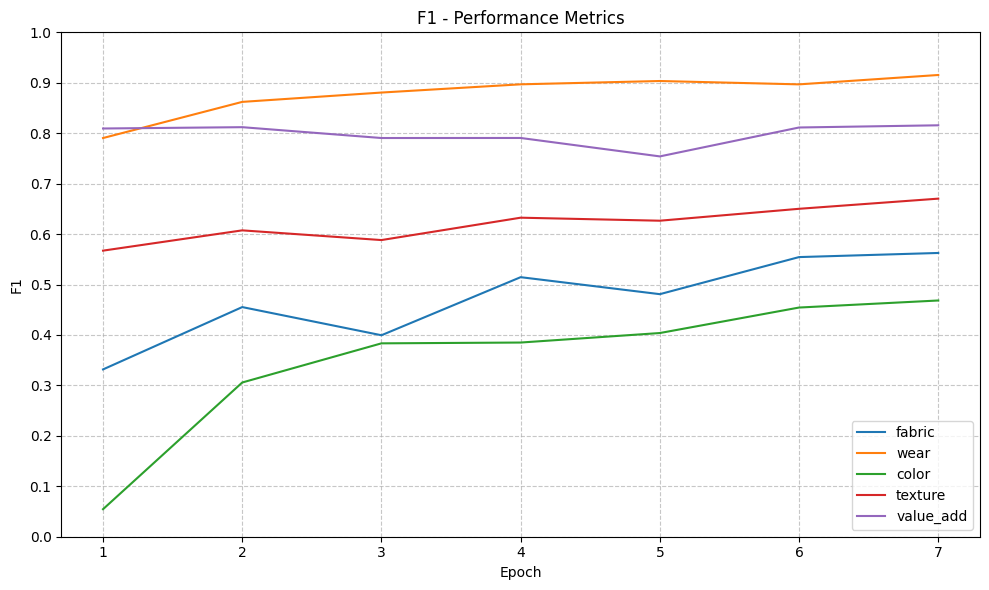

In [10]:
from my_utils.plot_utils import compare_tasks_for_metric

compare_tasks_for_metric(history, 'f1', show_losses=False)

In [11]:
from my_utils.eval_utils import parse_task_metrics

task_metrics, classwise_metrics = parse_task_metrics(history, verbose=True)

pd.DataFrame.from_dict(task_metrics, orient='index').T.round(2)

Best Epoch #: 4


,fabric,wear,color,texture,value_add
f1,0.51,0.90,0.38,0.63,0.79
precision,0.69,0.91,0.69,0.76,0.80
recall,0.41,0.89,0.27,0.54,0.78
accuracy,0.39,0.86,0.06,0.39,0.71


In [12]:
from IPython.display import display
from my_utils.eval_utils import load_task_metrics_for_test
import pandas as pd

current_model_metrics, current_model_claswise_metrics = parse_task_metrics(history)
baseline_metrics, baseline_classwise_metrics = load_task_metrics_for_test('../data/model_weights/test_metrics-best_model-resnet18_baseline.pt.json')

print("Efficient Net B4 Performance:")
display(pd.DataFrame.from_dict(current_model_metrics, orient='index').T.round(2))

print("\nBaseline Performance (Resnet 18):")
display(pd.DataFrame.from_dict(baseline_metrics, orient='index').T.round(2))

Efficient Net B4 Performance:


,fabric,wear,color,texture,value_add
f1,0.51,0.90,0.38,0.63,0.79
precision,0.69,0.91,0.69,0.76,0.80
recall,0.41,0.89,0.27,0.54,0.78
accuracy,0.39,0.86,0.06,0.39,0.71



Baseline Performance (Resnet 18):


,fabric,wear,color,texture,value_add
f1,0.48,0.85,0.48,0.58,0.73
precision,0.64,0.90,0.64,0.75,0.75
recall,0.39,0.80,0.39,0.48,0.70
accuracy,0.38,0.79,0.09,0.35,0.65


In [13]:
from my_utils.eval_utils import compare_task_with_baseline

compare_task_with_baseline(baseline_metrics, current_model_metrics, metrics=['f1', 'accuracy'], baseline_model_name='ResNet18', new_model_name='EfficientNet B4')

,Metric,Task,Baseline (ResNet18),EfficientNet B4,Delta
0,f1,fabric,0.48,0.51,0.03
1,f1,wear,0.85,0.90,0.05
2,f1,color,0.48,0.38,-0.10
3,f1,texture,0.58,0.63,0.05
4,f1,value_add,0.73,0.79,0.06
5,accuracy,fabric,0.38,0.39,0.02
6,accuracy,wear,0.79,0.86,0.07
7,accuracy,color,0.09,0.06,-0.03
8,accuracy,texture,0.35,0.39,0.05
9,accuracy,value_add,0.65,0.71,0.06
